# Plume rise deliverable CATRINE

From proposal:
- _"By performing high resolution eddy-resolving simulations under different atmospheric conditions in WP3, we will test the impact of plume rise, and compare the results to existing parametrizations of plume rise (e.g. Orkomi et al., 2018)"_
- _"work on the computational efficiency of the LES code to test impact of chemistry and plume rise model in very high resolution simulations of plumes from point"_
- _"This task addresses plume rise and chemistry of large point sources. Point sources will be simulated at very high resolution, and simulations will account for the heat released by the facility and the non-linear NOx chemistry in the plume. A recommended chemistry scheme will be ported to GPU to allow for fast simulations and to assess the effects of wind and atmospheric stability on plume rise and chemistry. Observations of polar orbiting (TROPOMI) and geostationary (GEMS) satellite observations will be used to evaluate the simulations."_
sources."_

## Work done

1. Developed new emission module which uses 3D emission fields (with limited vertical extent):
- More flexibility for emissions (time and space varying)
- Computationally more efficient for a large amount of point sources
- Old option for Gaussian blobs, but also option to constrain the emission to a single grid point. With the new flux limited advection schemes, single grid point emission work fine.
- More accurate implementation of heat release: by supplying both the emission volume flux (Q) and emission temperature (Te) to LES, we can more accurately account for the buoyancy production by including the actual temperature difference between emission and environment. 
2. Run ensemble of idealised cases (see next section).
3. Evaluate plume rise parameterisations.

## Plan for report

LES can resolve plume rise, but the accuracy likely depends on the emission/buoyancy strength vs. the resolution of LES. When including a weak emission at a coarse (~100 m) resolution, the buoyancy might be artificially diluted over a larger volume then reality, potentially influencing plume rise. Is this the case, should we use a parameterised plume rise instead of resolving it?

We test this by running an ensemble of idealised cases under different emission strengths and atmospheric conditions:

- Case = (unstable, neutral, stable)
- Qe = (0, 0.5, 1, 5, 10, 30) MW
- U = (1, 5, 10) m/s
- resolution = (10, 25, 50, 100, 200) m (likely different for stable case)

With the lowest wind speed excluded from the stable case, this results in an ensemble of 300 LES experiments.

In the absence of observations, we use the highest resolution as the "truth".

## Two main questions:
1. How well does low-resolution LES work when resolving plume rise?
2. How well do existing plume rise models work for these cases? Compare simple (OPS model) and complex (Briggs 1984) methods.

In [1]:
#%matplotlib ipympl

import matplotlib.pyplot as pl
import matplotlib.colors as colors
import matplotlib.ticker as ticker

import colormaps as cmaps

import numpy as np
import xarray as xr

from microhhpy.io import xr_open_groups
from microhhpy.thermo import Basestate_dry, exner

from plume_rise_eqs import calc_dh_convective, calc_dh_stable

In [2]:
from matplotlib.scale import ScaleBase, register_scale
from matplotlib.transforms import Transform
from matplotlib.ticker import AutoLocator

class SqrtTransform(Transform):
    input_dims = output_dims = 1
    is_separable = True

    def transform_non_affine(self, x):
        return np.sign(x) * np.sqrt(np.abs(x))

    def inverted(self):
        return InvertedSqrtTransform()

class InvertedSqrtTransform(Transform):
    input_dims = output_dims = 1
    is_separable = True

    def transform_non_affine(self, y):
        return np.sign(y) * (y ** 2)

    def inverted(self):
        return SqrtTransform()

# Define the scale
class SqrtScale(ScaleBase):
    name = 'sqrt'

    def __init__(self, axis, **kwargs):
        super().__init__(axis)

    def get_transform(self):
        return SqrtTransform()

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(AutoLocator())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return vmin, vmax

register_scale(SqrtScale)

In [3]:
"""
Naming convention simulations:
`{case}_{Qe}_{U}_{res}m`
- case = neutral/convective/stable
- Qe   = heat output (MW).
- U    = wind speed (m/s).
- res  = horizontal resolution.
"""

# Fixed emission height for ALL cases.
emission_height = 100.

class Case:
    def __init__(self, path, name):

        # Default statistics.
        self.ds = xr_open_groups(f'{path}/stats/{name}/plume_rise.default.0000000.nc')

        # Average profiles over last two hours.
        self.dsm = self.ds.sel(time=slice(14400, 21600)).mean(dim='time')

        # Calcuate base state, needed for density, which isn't part of the stats?!
        pbot = 1e5
        zsize = 600 if 'stable' in name else 2400
        self.bs = Basestate_dry(self.ds.th[0,:].values, pbot, self.ds.z.values, zsize, remove_ghost=True)

        # Read spanwise and time averaged cross-section.
        self.ds_2d = xr.open_dataset(f'{path}/cross/{name}/co2_ymean_14400_21600.xz.nc', decode_times=False).squeeze()

        x = self.ds_2d.x.values

        # Averaged over last part domain.
        xsize = 3200 if 'stable' in name else 12800
        self.x0 = 0.8 * xsize
        self.x1 = xsize

        self.ds_1d = self.ds_2d.sel(x=slice(self.x0, self.x1)).mean(dim='x')

        # Height of max CO2 concentration as function of distance.
        co2 = self.ds_2d.co2_ymean.values
        z = self.ds_2d.z.values

        # Exclude emission itself.
        x0 = 400 if 'stable' in name else 1200
        i0 = np.abs(x-x0).argmin()

        self.co2_max = co2.max(axis=0)
        self.co2_max[:i0] = 0.

        self.k_max = co2.argmax(axis=0)
        self.z_max = z[self.k_max]

        # Only count peak if concentration is >10% larger than mean. Otherwise it is ... not a peak.
        # Mean CO2 over depth where CO2 > background concentration.
        z_max = 250 if 'stable' in name else 1250.
        k = np.abs(z-z_max).argmin()
        self.co2_mean = co2[:k, :].mean(axis=0)

        self.has_peak = self.co2_max / self.co2_mean > 1.05

        self.co2_max[~self.has_peak] = -1
        self.z_max  [~self.has_peak] = -1
        self.k_max  [~self.has_peak] = -1

        # Height, strength, and x-location of peak.
        self.z_peak = self.z_max.max()
        self.i_peak = np.argmax(self.z_max)
        self.co2_peak = self.co2_max[self.i_peak]


def case_name(sim, Q, u, res):
    """
    Get case name following naming convention.
    """
    def fmt_Q(n):
        return str(int(n)) if n == int(n) else str(n)
    return f'{sim}_Q{fmt_Q(Q)}_U{u}_{res}m'


def get_range(name, case):
    """
    Get range of parameter space for given case.
    """
    if case == 'stable':
        if name == 'u':
            return np.array([5, 10])
        elif name == 'res':
            return np.array([5, 10, 25, 50, 100, 200])
    else:
        if name == 'u':
            return np.array([1, 5, 10])
        elif name == 'res':
            return np.array([10, 25, 50, 100, 200])

    if name == 'Q':
        return np.array([0, 0.5, 1, 5, 10, 30])


def get_experiments(case):
    """
    Get list of all cases for given experiment.
    """
    res_range = get_range('res', case)
    u_range = get_range('u', case)
    Q_range = get_range('Q', case)

    cases = []
    for res in res_range:
        for u in u_range:
            for Q in Q_range:
                cases.append(case_name(case, Q, u, res))
    
    return cases


def letter(n):
    """
    Get letter: 0=a, 1=b, etc.
    """
    return chr(ord('a') + n)

In [4]:
"""
Read/parse all cases.
"""
path = '/home/scratch2/bart/microhh/catrine_plume_rise/'

stable = get_experiments('stable')
neutral = get_experiments('neutral')
convective = get_experiments('convective')

cases = {}
for case in stable + neutral + convective:
    cases[case] = Case(path, case)

## Cross-sections

Averaged in the spanwise direction, and over last two hours of simulation.

Probably used to illustrate the cases, perhaps show a small collection to demonstrate plume behavior in LES.

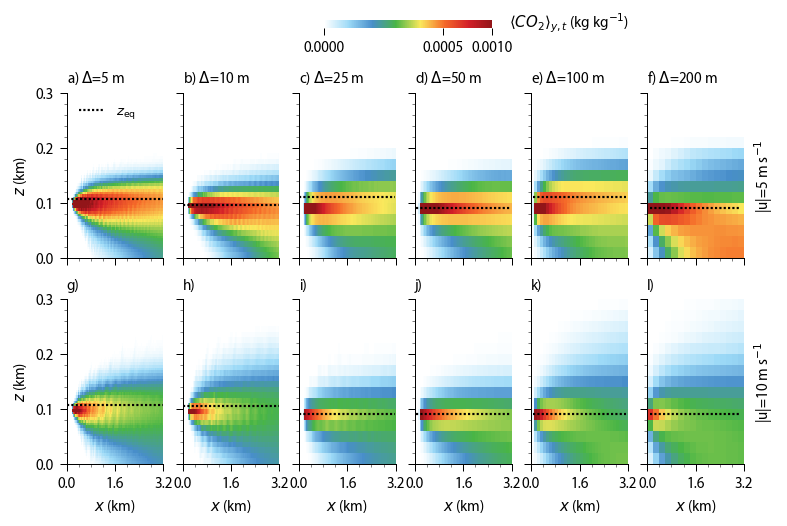

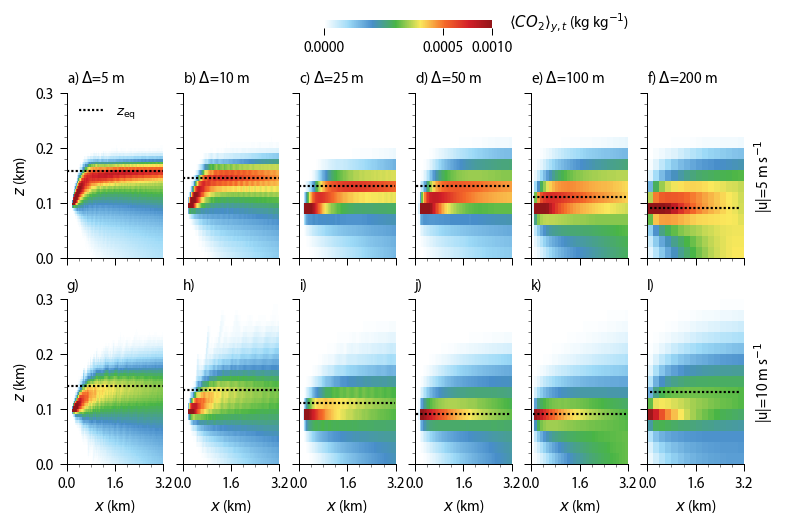

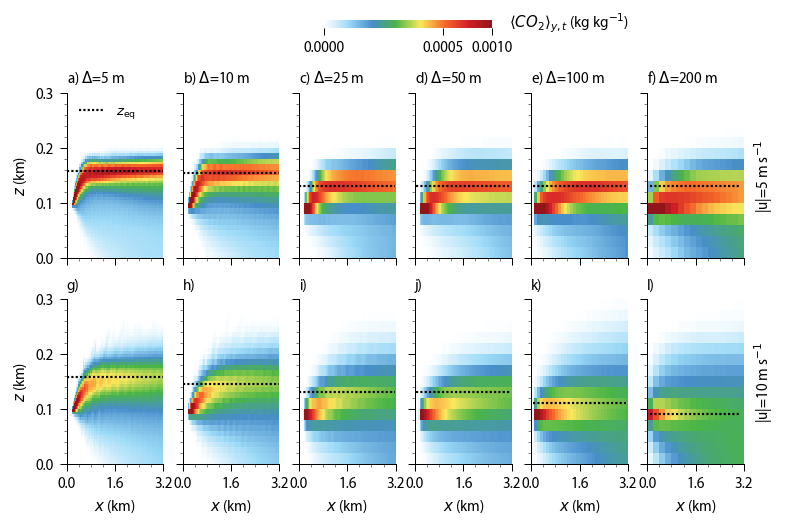

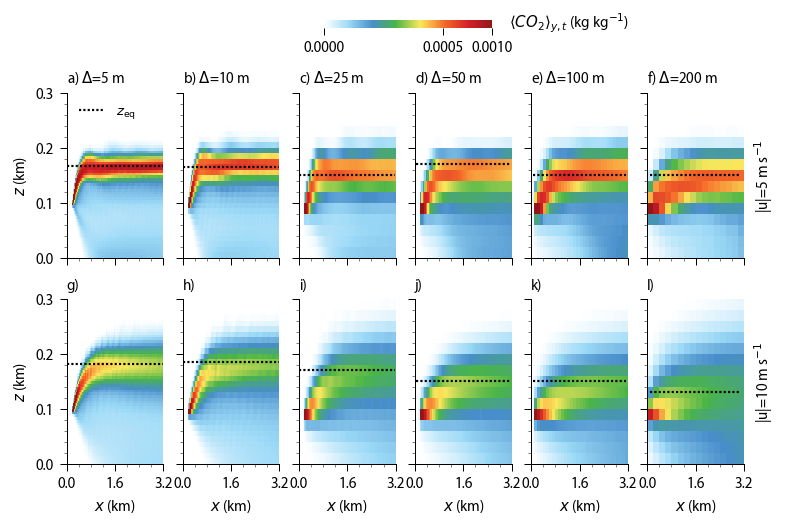

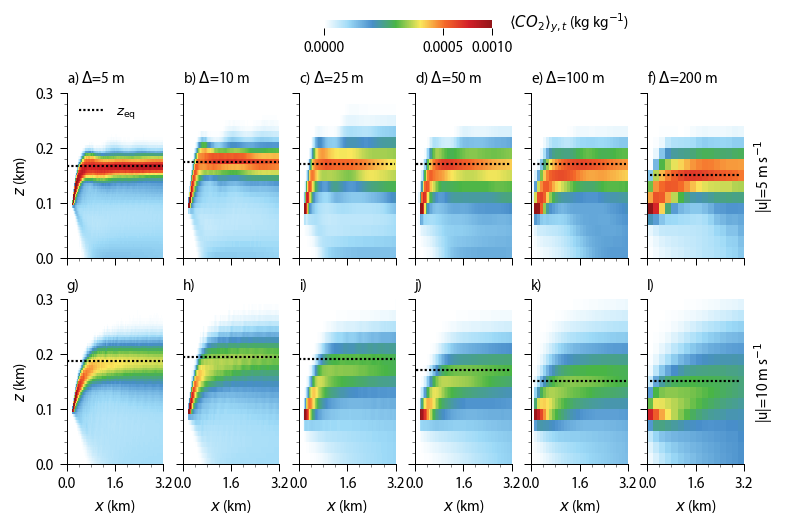

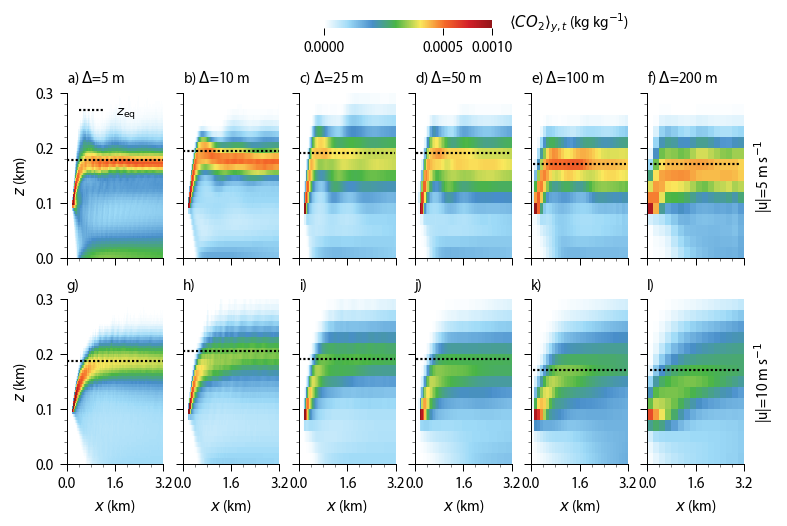

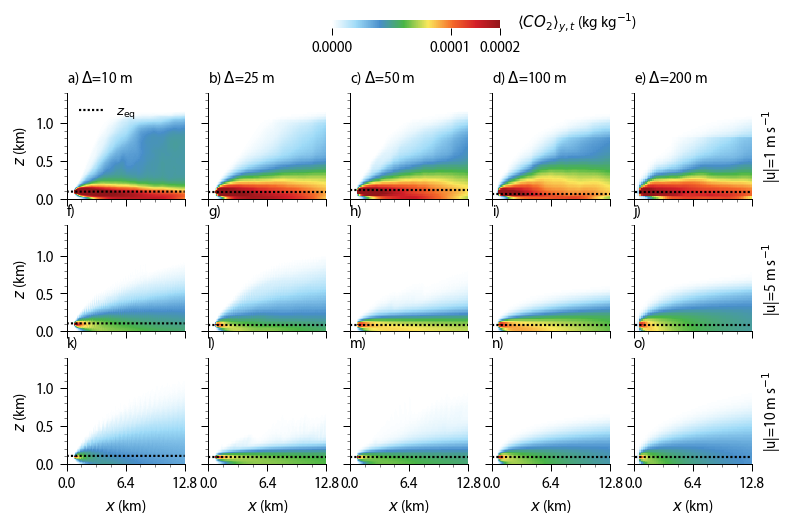

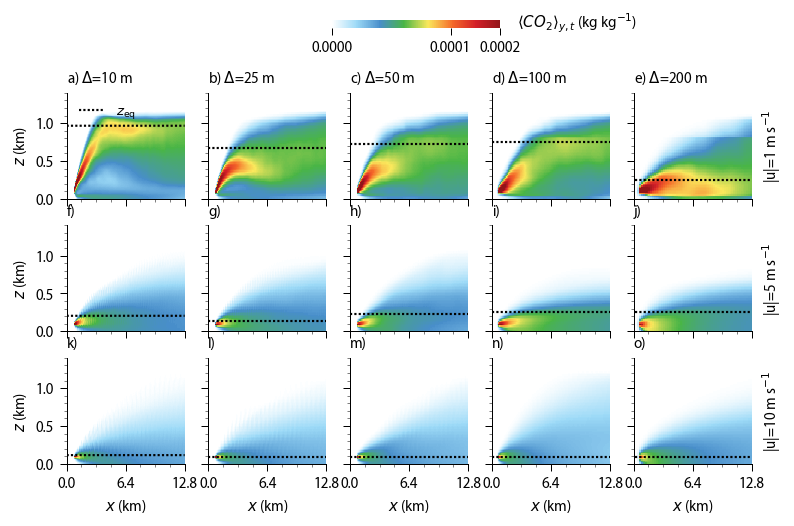

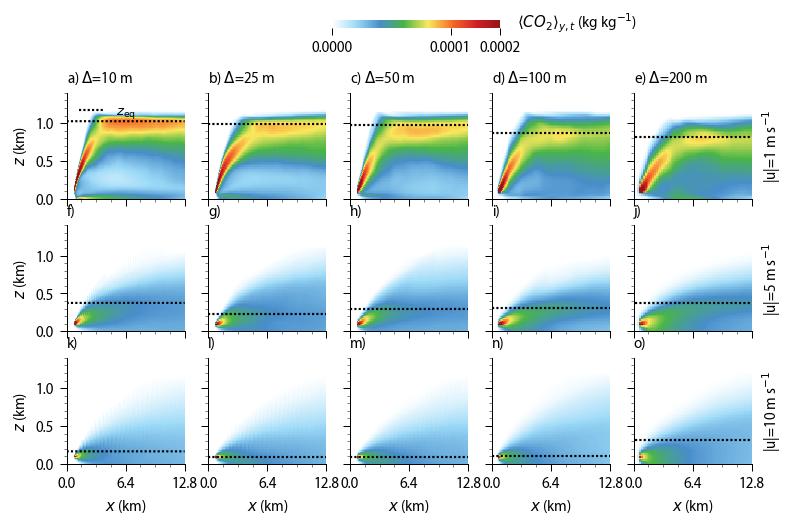

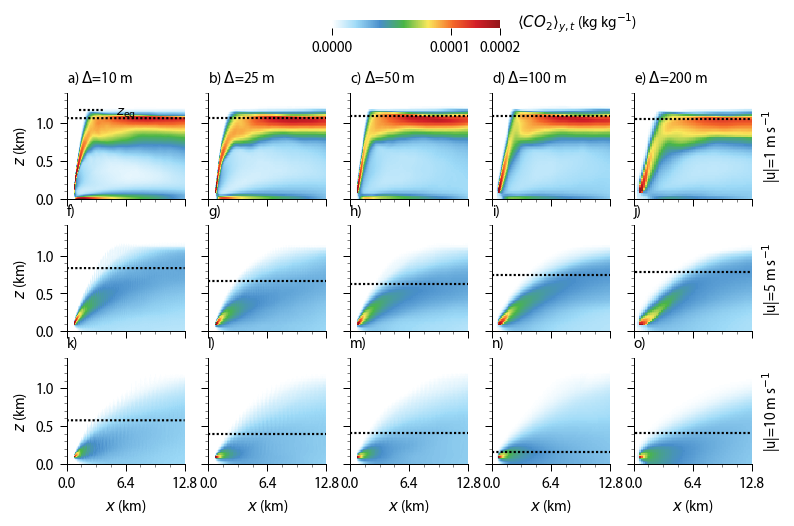

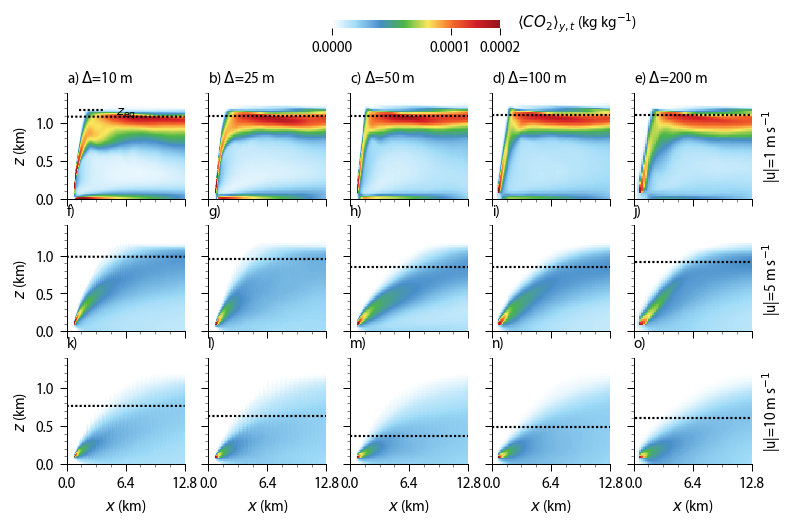

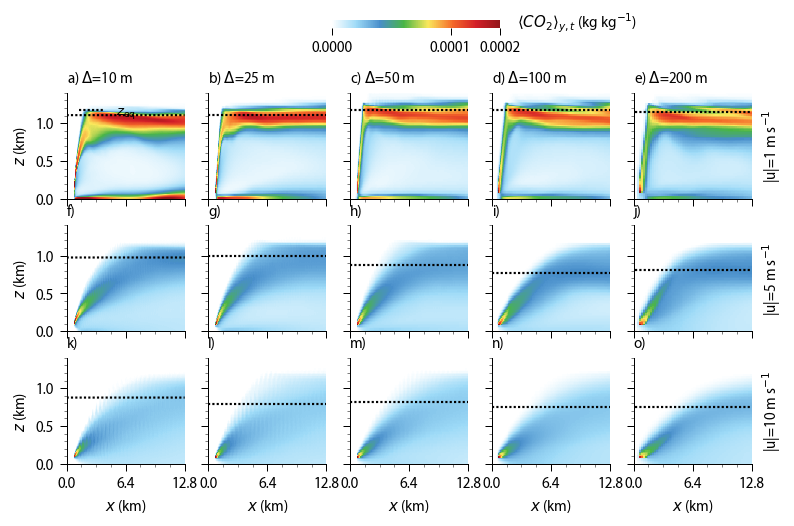

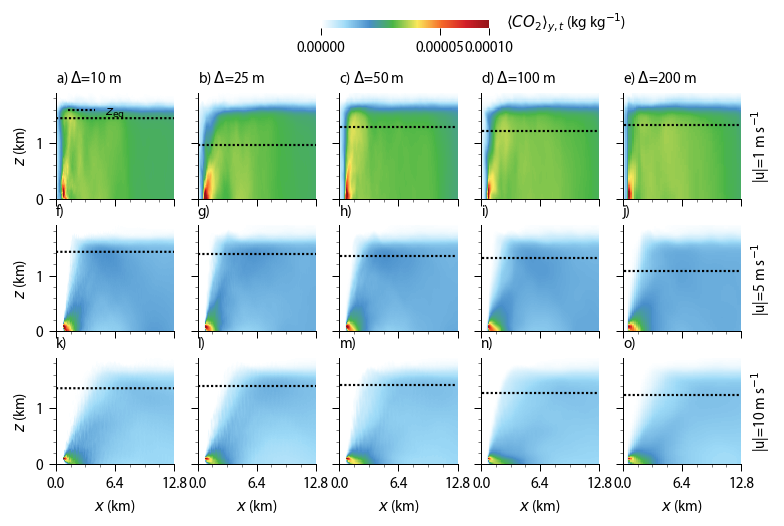

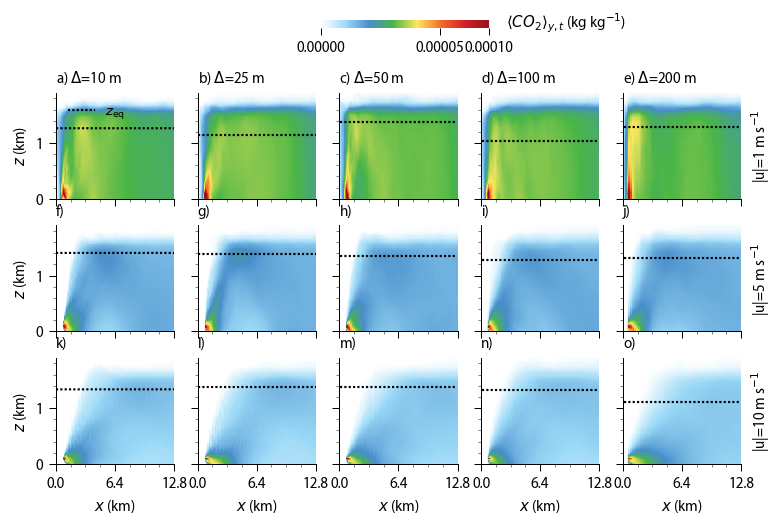

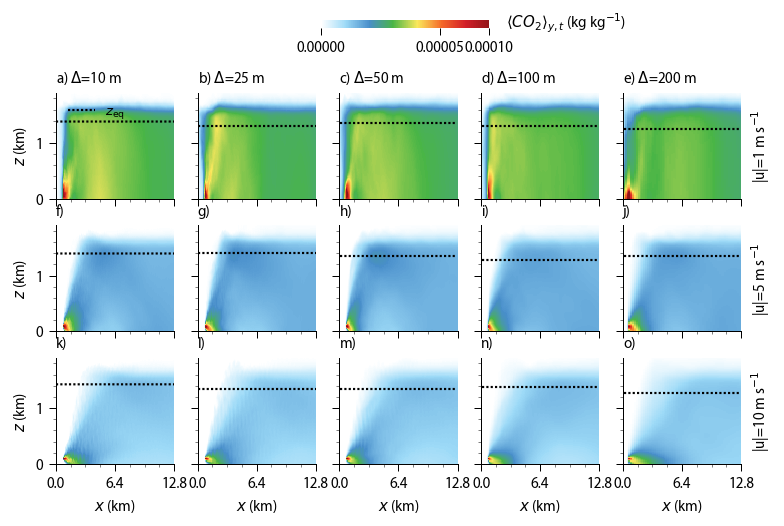

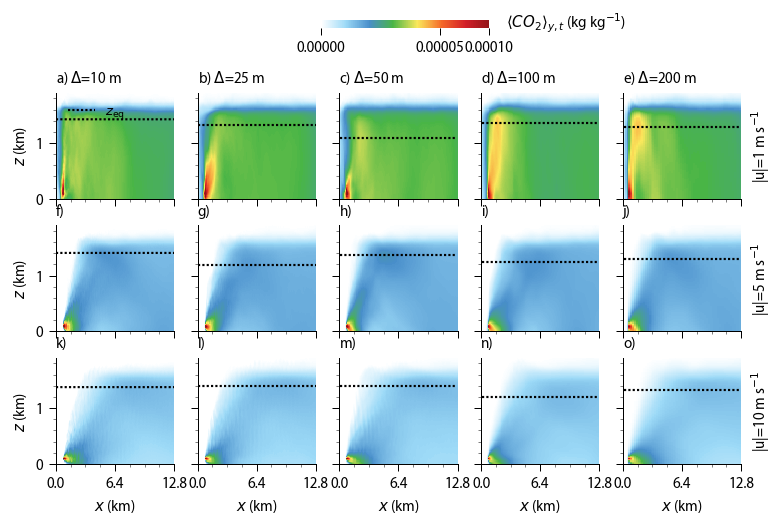

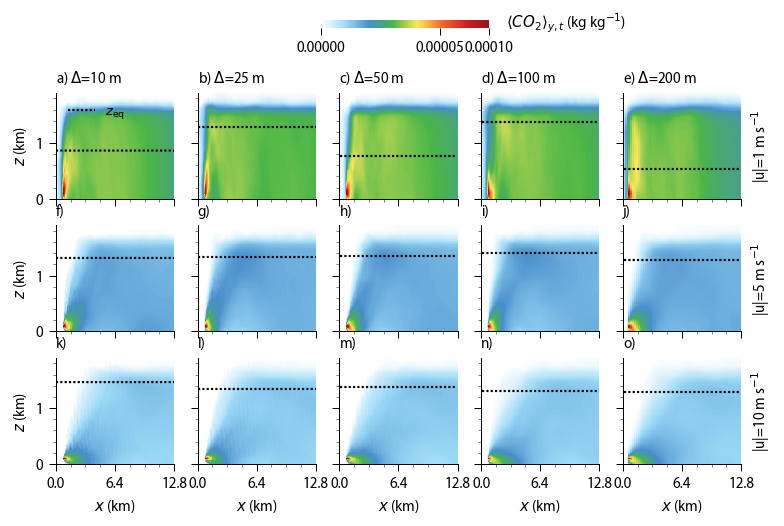

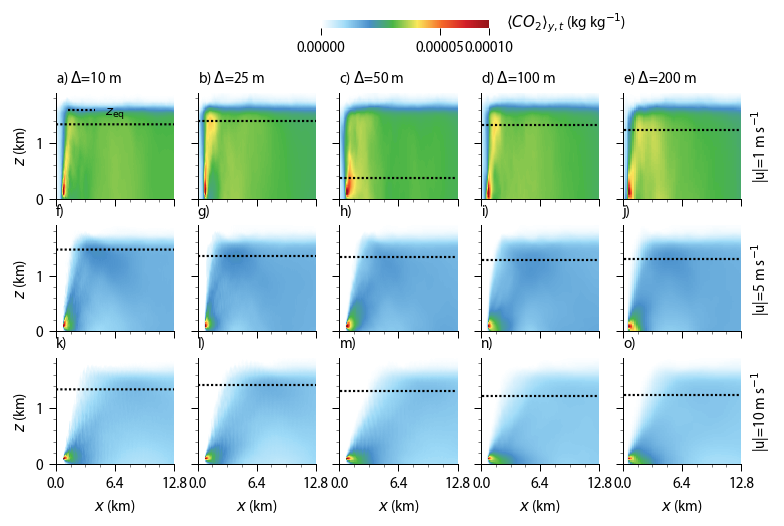

In [48]:
"""
First check: plot crosses, averaged spanwise and in time (14400 - 21600 sec.)
"""
pl.close('all')

def plot_cross(sim, Q, vmax, zmax, fig_height):

    stable = True if 'stable' in sim else False

    cmap = cmaps.WhiteBlueGreenYellowRed
    norm = colors.PowerNorm(gamma=0.5, vmin=0, vmax=vmax)

    res_range = get_range('res', sim)
    u_range = get_range('u', sim)

    ncol = res_range.size
    nrow = u_range.size

    fig, axs = pl.subplots(nrow, ncol, figsize=(7, fig_height))
    #y = 0.92 if stable else 0.94
    #pl.figtext(0.05, y, rf'Case = {sim}, Q = {Q} MW')

    for j,u in enumerate(u_range):
        for i,res in enumerate(res_range):

            n = i+j*res_range.size
            ax = axs[j,i]
            title = rf'{letter(n)}) $\Delta$={res} m' if j==0 else rf'{letter(n)})'
            ax.set_title(title, loc='left')

            case = cases[case_name(sim, Q, u, res)]
            pc=ax.pcolormesh(case.ds_2d.x/1000, case.ds_2d.z/1000, case.ds_2d.co2_ymean, cmap=cmap, norm=norm, rasterized=True)
            label = r'$z_\mathrm{eq}$' if j==0 and i==0 else ''
            ax.plot(case.ds_2d.x/1000, np.ones_like(case.ds_2d.x) * case.z_peak / 1000., 'k:', label=label)

            ax.set_ylim(0, zmax)

            if i==0 and j==0:
                ax.legend(loc='upper left', fontsize=8)

            if i==0:
                ax.set_ylabel(r'$z$ (km)')
            else:
                ax.set_yticklabels([])

            if j==u_range.size-1:
                ax.set_xlabel(r'$x$ (km)')
            else:
                ax.set_xticklabels([])

            if stable:
                ax.set_xticks([0, 1.6, 3.2])
            else:
                ax.set_xticks([0, 6.4, 12.8])

    pl.tight_layout()

    # Adjust margins for colorbar and right (wind speed) labels.
    tm = 0.81 #if stable else 0.86
    tl = 0.93 #if stable else 0.94
    pl.subplots_adjust(top=tm, right=0.9, wspace=0.20, hspace=0.25)

    # Manually add colorbar to top of figure.
    cax=fig.add_axes([0.4, tl, 0.2, 0.015])
    cb=pl.colorbar(pc, cax=cax, orientation='horizontal')
    cb.outline.set_visible(False)
    cb.ax.tick_params(axis='both', which='minor', length=0, width=0)
    pl.figtext(0.62, tl, r'$\langle CO_2 \rangle_{y,t}$ (kg kg$^{-1}$)')

    # Add wind speeds right of columns.
    for j in range(nrow):
        p = axs[j,-1].get_position()
        pl.figtext(p.x1+0.01, 0.5*(p.y0+p.y1), ha='left', va='center', rotation=90, s=rf'|u|={u_range[j]} m s$^{{{-1}}}$')

    name = f'cross_{sim}_Q'
    pl.savefig(f'figs/cross_{sim}_{Q}.png', bbox_inches='tight')
    pl.savefig(f'figs/cross_{sim}_{Q}.pdf', bbox_inches='tight')

    

Q_range = [0, 0.5, 1, 5, 10, 30]
#Q_range = [10]

case = 'stable'
for Q in Q_range:
    plot_cross(case, Q, vmax=0.001, zmax=0.3, fig_height=4.5)

case = 'neutral'
for Q in Q_range:
    plot_cross(case, Q, vmax=0.0002, zmax=1.4, fig_height=4.5)

case = 'convective'
for Q in Q_range:
    plot_cross(case, Q, vmax=0.0001, zmax=1.9, fig_height=4.5)

## Profiles at location of highest peak.

Plumes typicall behave like:

![](figs/plume_rise_algo.png)

The plume rise height algorithm tracks the height of the peak, as long as the peak is at least 10% higher than the mean concentration, calculated over the boundary layer depth. This prevents the algorithm from picking a random maximum when the plume is well-mixed. 

The profiles below show the vertical profile at the downwind location of the maximum peak.

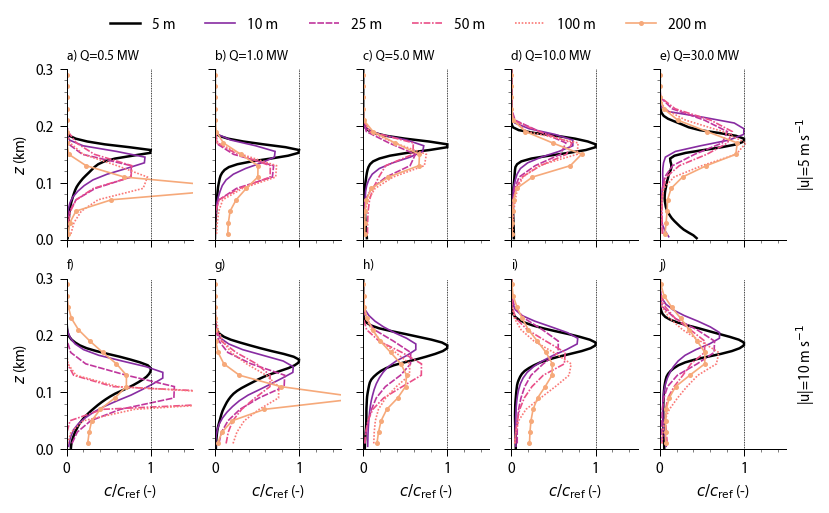

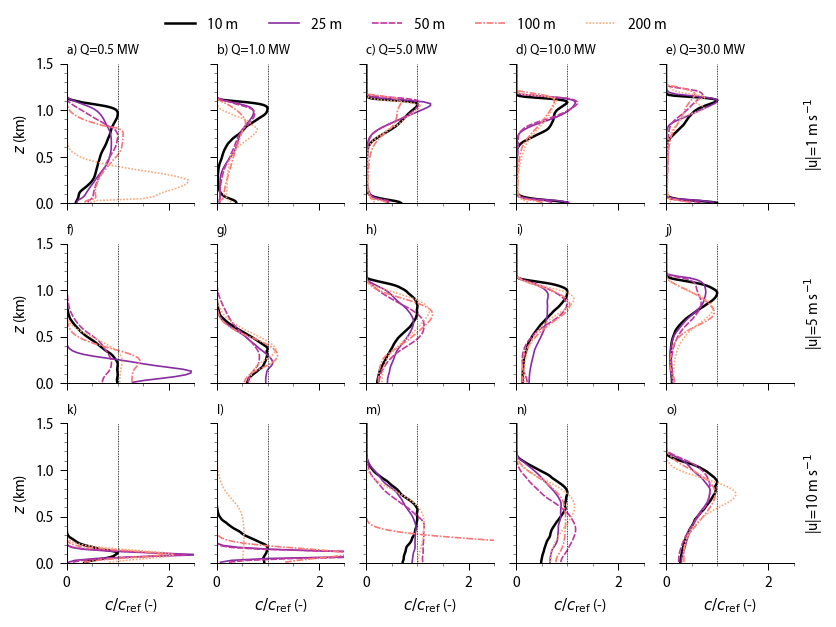

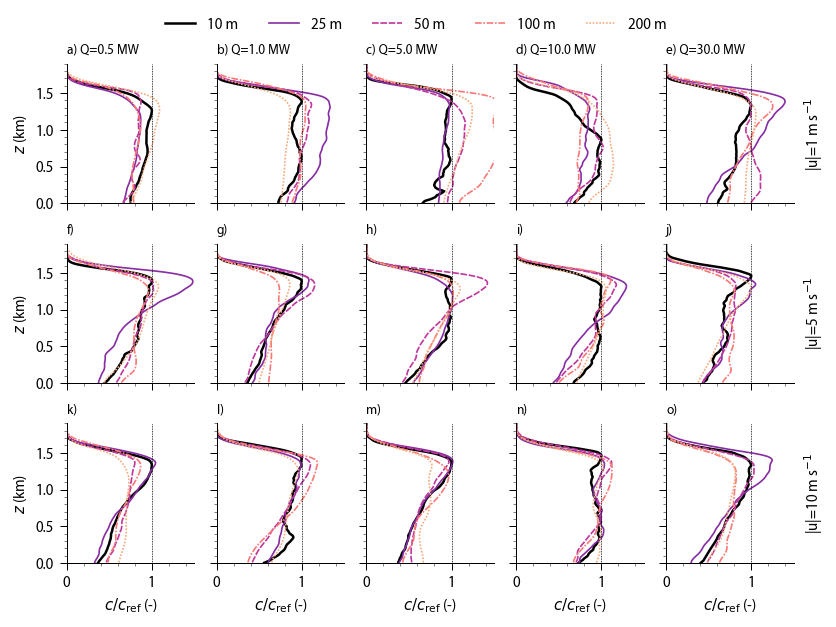

In [6]:
pl.close('all')

def plot_peak_profiles(sim, x_max, y_max, fig_height):

    stable = True if 'stable' in sim else False

    Q_range = get_range('Q', sim)[1:]
    res_range = get_range('res', sim)
    u_range = get_range('u', sim)

    # Create discrete colors.
    cmap = cmaps.agsunset
    cc = cmap(np.linspace(0, 0.8, len(res_range)))

    #cmap = pl.cm.magma
    #cc = cmap(np.linspace(0, 0.8, len(res_range)))
    cc[0] = [0, 0, 0, 1]

    ls = ['-', '-', '--', '-.', ':', '-o']

    ncol = Q_range.size
    nrow = u_range.size

    fig, axs = pl.subplots(nrow, ncol, figsize=(7, fig_height))
    #pl.suptitle(f'Case = {sim}')

    for j,u in enumerate(u_range):
        for i,Q in enumerate(Q_range):

            ax = axs[j,i]
            n = i+j*Q_range.size
            title = rf'{letter(n)}) Q={Q} MW' if j==0 else rf'{letter(n)})'
            ax.set_title(title, loc='left', size=8)

            # Normalise profiles with peak concentration reference case.
            case = cases[case_name(sim, Q, u, res_range[0])]
            norm_val_x = case.ds_2d.co2_ymean[:, case.i_peak].max()
            norm_val_z = case.z_peak/1000

            for k,res in enumerate(res_range):
                case = cases[case_name(sim, Q, u, res)]
                lw = 1.5 if k==0 else 1

                ax.plot(case.ds_2d.co2_ymean[:, case.i_peak] / norm_val_x, case.ds_2d.z/1000, ls[k], ms=2, linewidth=lw, label=f'{res} m', color=cc[k])

            #ax.plot([0, x_max], [1, 1], 'k:', linewidth=0.5)
            ax.plot([1, 1], [0, y_max], 'k:', linewidth=0.5)    
            ax.set_ylim(0, y_max)
            ax.set_xlim(0, x_max)

            if i>0:
                ax.set_yticklabels([])
            if j<u_range.size-1:
                ax.set_xticklabels([])

            if i==0:
                ax.set_ylabel(r'$z$ (km)')
            if j==u_range.size-1:
                ax.set_xlabel(r'$c/c_\mathrm{ref}$ (-)')


    # Add single legend above figure.
    pl.tight_layout()
    tm = 0.83 if stable else 0.86
    fig.subplots_adjust(top=tm, right=0.95)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=res_range.size, bbox_to_anchor=(0.5, 0.95), frameon=False)

    # Add wind speed labels.
    for j in range(nrow):
        p = axs[j,-1].get_position()
        pl.figtext(p.x1+0.01, 0.5*(p.y0+p.y1), ha='left', va='center', rotation=90, s=rf'|u|={u_range[j]} m s$^{{{-1}}}$')

    pl.savefig(f'figs/profiles_{sim}.png', bbox_inches='tight')
    pl.savefig(f'figs/profiles_{sim}.pdf', bbox_inches='tight')


plot_peak_profiles('stable', x_max=1.5, y_max=0.3, fig_height=4.5)
plot_peak_profiles('neutral', x_max=2.5, y_max=1.5, fig_height=5.5)
plot_peak_profiles('convective', x_max=1.5, y_max=1.9, fig_height=5.5)

## Plume rise Briggs 1984

Method for calculating plume rise in variably statified atmosphere. Still most used model in literature (?), with original params from 1984.

In [7]:
# Constants.
g = 9.81
T0 = 273.15
cp = 1005.

def calc_plume_rise(T, U, z, zh, ze, Ve, Te, method='both'):
    """
    Calculate plume rise using entraining plume model Briggs.

    Parameters:
    ----------
    T : np.ndarray, dim (1,)
        Absolute temperature (K)
    U : np.ndarray, dim (1,)
        Absolute wind speed (m/s)
    z : np.ndarray, dim (1,)
        Full model level height (location T, U)
    zh : np.ndarray, dim (1,)
        Half model level height (location fb)
    ze : float
        Emission height (m)
    Ve : float
        Emission volume flux (m3 / s)
    Te : float
        Emission temperature (K)
    method : string
        Method for using buoyancy decrease. Either:
        'both' : use max buoyancy decrease for straight and bend plumes.
        'straight': use buoyancy decrease for straight plumes
        'bend': use buoyancy decrease for bend plumes

    returns:
        fb : np.ndarray with buoyancy flux as function of height.
        zp : float, plume equilibrium height.
    """

    def calc_dfb(fb0, T, U, dTdz, zm, zp):
        """
        Calculate bouyancy decrease with jump in model level from `zm` to `zp`.

        parameters:
        ----------
        fb0 : float
            Initial buoyancy at stack (NOTE: this is different in most papers!!)
        T : float
            Absolute temperature current model layer.
        U : float
            Wind speed current model layer.
        dTdz : float
            Absolute temperature gradient.
        zm : float
            Bottom height current layer.
        zp : float
            Top height current layer.
        """
        # Heights are relative to stack height!
        zp -= ze
        zm -= ze

        # Stability parameter, Briggs 1984, Eq 8.14.
        s = g / T * (dTdz + g/cp)

        # Buoyancy decrease straight plumes, Briggs 1984, Eq 8.84.
        # NOTE: this uses `Fj-1**1/3` instead of `Fb0**1/3` in most papers, which I think is incorrect, based on what Briggs (1984) writes.
        dfb1 = 0.015 * s * fb0**(1/3) * (zp**(8/3) - zm**(8/3))

        # Buoyancy decrease bend plumes, Briggs 1984, Eq 8.85.
        dfb2 = 0.053 * s * U * (zp**3 - zm**3)

        if method == 'both':
            return max(dfb1, dfb2)
        elif method == 'straight':
            return dfb1
        elif method == 'bend':
            return dfb2
        else:
            raise Exception('Invalid method.')

    # Store buoyancy in array for plotting.
    fb = np.zeros_like(zh)

    # Find first half model level above stack height. First increment will go
    # from stack to model level, thereafter from model level to level.
    kstart = np.searchsorted(zh, ze, side='right')

    # Linearly interpolate temperature and wind to stack height.
    Ti = np.interp(ze, z, T)
    Ui = np.interp(ze, z, U)

    # Buoyancy at stack height, Akingunola et al. Eq 1.
    fb0 = g / np.pi * Ve * (Te - Ti) / Te
    fb[kstart-1] = fb0

    # Step from stack height to first half model level.
    dTdz = (T[kstart] - T[kstart-1]) / (z[kstart] - z[kstart-1])
    dfb = calc_dfb(fb0, Ti, Ui, dTdz, ze, zh[kstart])
    fb[kstart] = fb[kstart-1] - dfb

    # Loop over model levels until buoyancy becomes negative.
    for k in range(kstart, zh.size-2):
        dTdz = (T[k+1] - T[k-1]) / (z[k+1] - z[k-1])
        dfb = calc_dfb(fb0, T[k], U[k], dTdz, zh[k], zh[k+1])
        fb[k+1] = fb[k] - dfb

        if fb[k+1] < 0:
            break

    # Interpolate height where buoyancy is zero, as final plume rise height.
    dfb = fb[k] - fb[k+1]
    f = 1 - fb[k] / (fb[k] - fb[k+1])
    z_eq = f * zh[k] + (1-f) * zh[k+1]

    return fb, z_eq

Text(0, 0.5, 'z (km)')

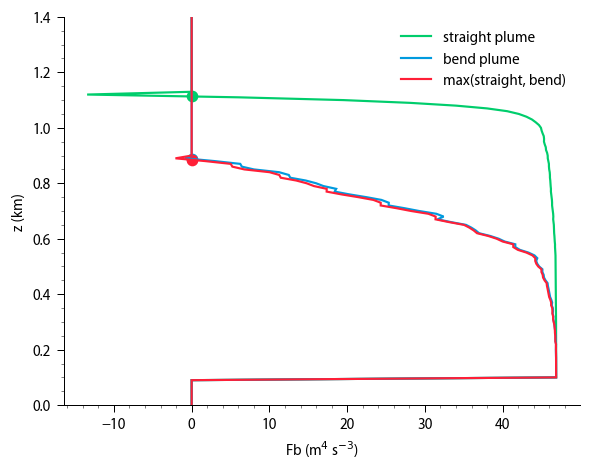

In [8]:
"""
Example of plume rise using Briggs model, for report?
"""

case = cases['neutral_Q5_U5_10m']
#case = cases['stable_Q0_U5_5m']

# Short-cuts.
dsm = case.dsm
p = case.bs.p
z = dsm.z.values
zh = dsm.zh.values

# Emission values. Use same assumption as used in
# Q -> Te + Ve conversion LES case.
Qe = 5
Te = T0 + 50.
Tref = T0 + 15.
rho = 1.
Ve = Qe / (rho * cp * (Te - Tref) * 1e-6)

# Calculate absolute temperature and wind speed.
T = dsm.th.values * exner(p)
U = np.sqrt(dsm.u.values**2 + dsm.v.values**2)

fb1, z1 = calc_plume_rise(T, U, z, zh, emission_height, Ve, Te, method='both')
fb2, z2 = calc_plume_rise(T, U, z, zh, emission_height, Ve, Te, method='straight')
fb3, z3 = calc_plume_rise(T, U, z, zh, emission_height, Ve, Te, method='bend')

pl.figure(figsize=(5,4), layout='tight')

pl.plot(fb2, zh/1000, label='straight plume', color='C1')
pl.scatter(0, z2/1000, color='C1')

pl.plot(fb3, zh/1000, label='bend plume', color='C2')
pl.scatter(0, z3/1000, color='C2')

pl.plot(fb1, zh/1000, label='max(straight, bend)', color='C0')
pl.scatter(0, z1/1000, color='C0')

pl.legend()
pl.ylim(0, 1.400)
pl.xlabel(r'Fb (m$^4$ s$^{-3}$)')
pl.ylabel('z (km)')

## Plume rise parameterisations vs LES

In [15]:
"""
Plume rise: LES vs OPS model.
"""
pl.close('all')

"""
Calculate plume rise OPS model (=simple Briggs model).
"""
Qs_ops = np.linspace(0, 30, 128)
u_ops  = np.array([1, 5, 10])

dh_conv = np.zeros((Qs_ops.size, u_ops.size), dtype=np.float32)
dh_stab = np.zeros((Qs_ops.size, u_ops.size), dtype=np.float32)

s_ops = 9.81/290 * 0.006

for i in range(Qs_ops.size):
    for j in range(u_ops.size):
        dh_conv[i,j] = calc_dh_convective(Qs=Qs_ops[i], u=u_ops[j])
        dh_stab[i,j] = calc_dh_stable(Qs=Qs_ops[i], u=u_ops[j], s=s_ops)


"""
Calculate plume rise using Briggs 1984 entraining plume model.
"""
# Same assumptions as made in the LES case conversion Q -> Ve+Te.
Tref = T0 + 15
Te = T0 + 50
rho = 1.0

for sim in ['stable', 'neutral', 'convective']:

    Q_range = get_range('Q', sim)
    u_range = get_range('u', sim)
    res_range = get_range('res', sim)
    res = res_range[0]

    for Q in Q_range:
        for u in u_range:
            name = case_name(sim, Q, u, res)
            case = cases[name]
            dsm = case.dsm
            Ve = Q / (rho * cp * (Te - Tref) * 1e-6)

            T = dsm.th.values * exner(case.bs.p)
            U = np.sqrt(dsm.u.values**2 + dsm.v.values**2)
            z = dsm.z.values
            zh = dsm.zh.values

            case.fb1, case.z_eq_1 = calc_plume_rise(T, U, z, zh, emission_height, Ve, Te, method='both')
            case.fb2, case.z_eq_2 = calc_plume_rise(T, U, z, zh, emission_height, Ve, Te, method='straight')
            case.fb3, case.z_eq_3 = calc_plume_rise(T, U, z, zh, emission_height, Ve, Te, method='bend')

/tmp/ipykernel_1382803/2355611947.py:110: RuntimeWarning: invalid value encountered in scalar divide
  f = 1 - fb[k] / (fb[k] - fb[k+1])


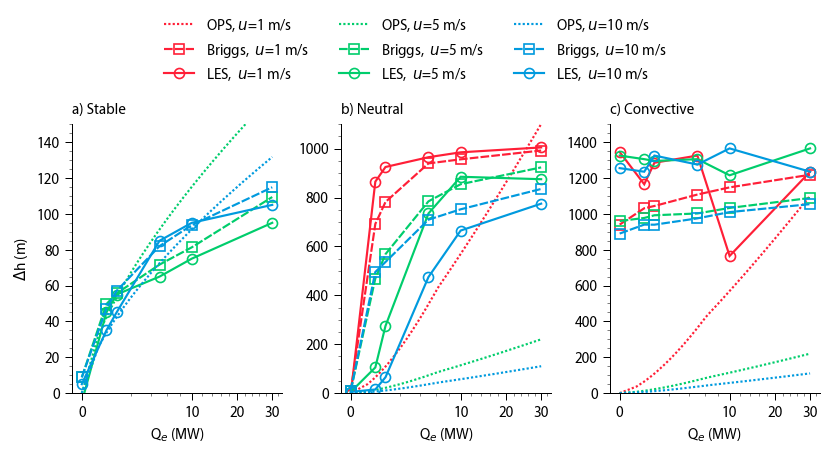

In [33]:
"""
Plot!
"""
pl.close('all')

fig = pl.figure(figsize=(7,4))

cc = ['C0', 'C1', 'C2']
plot_func = pl.plot

sim = 'stable'
Q_range = get_range('Q', sim)
res_range = get_range('res', sim)
u_range = get_range('u', sim)

ax=pl.subplot(131)
ax.set_xscale('sqrt')
pl.title('a) Stable', loc='left')

res = 10
for i,u in enumerate(u_range):
    ze_les = np.zeros(Q_range.size)
    ze_briggs = np.zeros(Q_range.size)

    for n, Q in enumerate(Q_range):
        name = case_name(sim, Q, u, res)
        case = cases[name]
        ze_les[n] = case.z_peak
        ze_briggs[n] = case.z_eq_1
    
    plot_func(Qs_ops, dh_stab[:,i+1], ':', color=cc[i+1], label=rf'OPS, $u$={u_ops[i]} m/s')
    plot_func(Q_range, ze_briggs-emission_height, '--s', color=cc[i+1], mfc='none', label=rf'Briggs,  $u$={u_range[i]} m/s')
    plot_func(Q_range, ze_les-emission_height, '-o', color=cc[i+1], mfc='none', label=rf'LES,  $u$={u_range[i]} m/s')

pl.ylim(0, 150)
pl.xlabel(r'Q$_e$ (MW)')
pl.ylabel(r'$\Delta$h (m)')


sim = 'neutral'
Q_range = get_range('Q', sim)
res_range = get_range('res', sim)
u_range = get_range('u', sim)

ax=pl.subplot(132)
ax.set_xscale('sqrt')
pl.title('b) Neutral', loc='left')

res = 10
for i,u in enumerate(u_range):
    ze_les = np.zeros(Q_range.size)
    ze_briggs = np.zeros(Q_range.size)

    for n,Q in enumerate(Q_range):
        name = case_name(sim, Q, u, res)
        case = cases[name]
        ze_les[n] = case.z_peak
        ze_briggs[n] = case.z_eq_1
    
    plot_func(Qs_ops, dh_conv[:,i], ':', color=cc[i], label=rf'OPS, $u$={u_ops[i]} m/s')
    plot_func(Q_range, ze_briggs-emission_height, '--s', color=cc[i], mfc='none', label=rf'Briggs,  $u$={u_range[i]} m/s')
    plot_func(Q_range, ze_les-emission_height, '-o', color=cc[i], mfc='none', label=rf'LES,  $u$={u_range[i]} m/s')

pl.ylim(0, 1100)
pl.xlabel(r'Q$_e$ (MW)')


sim = 'convective'
Q_range = get_range('Q', sim)
res_range = get_range('res', sim)
u_range = get_range('u', sim)

ax=pl.subplot(133)
ax.set_xscale('sqrt')
pl.title('c) Convective', loc='left')

res = 10
for i,u in enumerate(u_range):
    ze_les = np.zeros(Q_range.size)
    ze_briggs = np.zeros(Q_range.size)

    for n,Q in enumerate(Q_range):
        name = case_name(sim, Q, u, res)
        case = cases[name]
        ze_les[n] = case.z_peak
        ze_briggs[n] = case.z_eq_1
    
    plot_func(Qs_ops, dh_conv[:,i], ':', label=rf'OPS, $u$={u_ops[i]} m/s')
    plot_func(Q_range, ze_briggs-emission_height, '--s', color=cc[i], mfc='none', label=rf'Briggs,  $u$={u_range[i]} m/s')
    plot_func(Q_range, ze_les-emission_height, '-o', color=cc[i], mfc='none', label=rf'LES,  $u$={u_range[i]} m/s')

pl.ylim(0, 1500)
pl.xlabel(r'Q$_e$ (MW)')

pl.tight_layout()
fig.subplots_adjust(top=0.70)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.95), frameon=False)

pl.savefig('figs/plume_rise_param.png', bbox_inches='tight')
pl.savefig('figs/plume_rise_param.pdf', bbox_inches='tight')

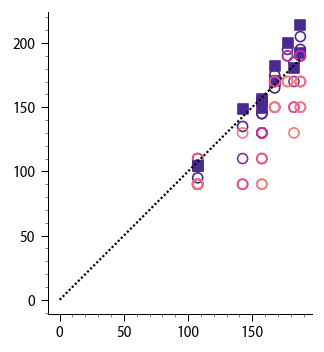

In [27]:
"""
Low-resolution LES vs Briggs parameterisations: who wins?
"""

pl.figure(layout='constrained')
pl.subplot(131, aspect='equal')

sim = 'stable'
Q_range = get_range('Q', sim)
res_range = get_range('res', sim)
u_range = get_range('u', sim)

cmap = cmaps.agsunset
cc = cmap(np.linspace(0, 0.8, len(res_range)))

z_max = 0
for Q in Q_range:
    for u in u_range:
        res = res_range[0]

        # Use Briggs plume rise from high-res simulation.
        case = cases[case_name(sim, Q, u, res_range[0])]
        z_ref = case.z_peak
        z_max = max(z_max, z_ref)

        pl.scatter(z_ref, case.z_eq_1, marker='s', color=cc[0])

        # Low(er)-resolution LESs
        for i,res in enumerate(res_range[1:]):
            case = cases[case_name(sim, Q, u, res)]
            pl.scatter(z_ref, case.z_peak, marker='o', color=cc[i], facecolor='none')

pl.plot([0, z_max], [0, z_max], 'k:')